In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from livelossplot import PlotLossesKeras
import lmfit

TARGET = 'fc'

print('tensorflow', tf.__version__)
print('keras', keras.__version__)
np.set_printoptions(precision=3, suppress=True)


tensorflow 2.15.0
keras 2.15.0


In [102]:
#Data from https://jenfitch.com/free-chlorine-orpmv-vs-ph-new/
df = pd.read_csv('orp.csv')
labels = df['ppm CL']
#labels = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.7, 2, 2.2, 2.5]
#df= df[df['ppm CL'].isin(labels)]
print(df)
df_orig = df.copy()
df_orig.pop('ppm CL')

vs = []
for column in df_orig:
    vals= df_orig[column].to_numpy()
    c = float(column)
    for i, v in enumerate(vals):
        vs.append((v, c, labels[i]))
dataset_orig = pd.DataFrame(vs, columns= ('orp', 'ph', 'fc'))
print(dataset_orig)

    6.9    7  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9    8  8.1  8.2  ppm CL
0   507  505  502  500  499  497  496  494  493  491  490  488  487    0.20
1   561  558  553  550  548  546  544  541  539  536  534  532  529    0.30
2   599  596  590  586  583  580  577  574  571  568  565  562  559    0.40
3   629  625  618  615  611  607  604  600  597  593  590  586  583    0.50
4   652  648  640  637  632  629  625  621  617  613  610  605  602    0.60
5   663  658  650  646  642  638  634  630  626  622  618  614  610    0.65
6   673  669  660  656  651  647  643  639  635  630  626  622  618    0.67
7   682  677  668  664  660  655  651  647  642  638  634  629  625    0.75
8   690  686  677  672  668  663  659  654  650  645  641  636  632    0.80
9   698  694  684  680  675  670  666  661  657  652  647  643  638    0.85
10  706  702  692  687  682  677  673  668  663  658  654  649  644    0.90
11  713  708  698  694  689  684  679  674  669  664  659  654  650    0.95
12  720  715

In [174]:
phmodels = {}
for i, ppm in enumerate(labels):
    data = df_orig[df['ppm CL'] == ppm]
    data =data.transpose()
    data.index = np.float64(data.index)
    lmodel = lmfit.models.LinearModel()
    xdata = data.index
    ydata = data[i]
    params = lmodel.guess(ydata, x=xdata)
    fit = lmodel.fit(ydata, params, x=xdata)    
    phmodels[ppm] = fit
    #plt.figure()
    #fit.plot_fit(title=ppm)
    #break
print(phmodels.keys())

dict_keys([0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.67, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.8, 2.0, 2.2, 2.5])


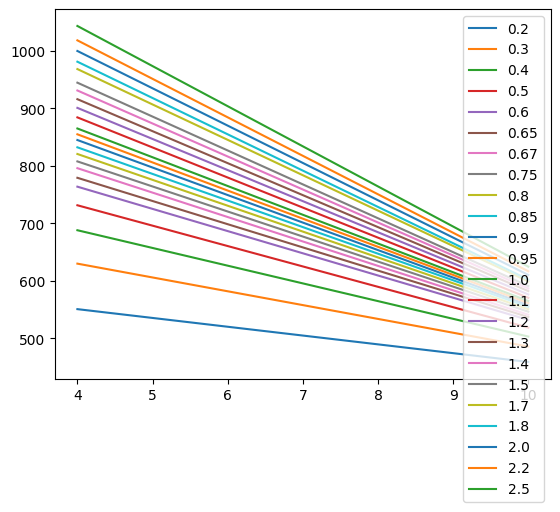

In [175]:
sample_xs = np.linspace( 40, 100, 100 ) / 10
sample_xs.shape
for key, mod in phmodels.items():
    plt.plot(sample_xs, mod.eval(x=sample_xs), label=key)
plt.legend()
plt.show()

In [176]:
models = {}
for ph in df_orig.columns:
    xdata =df[str(ph)].to_numpy()
    ydata = df['ppm CL'].to_numpy()
    lmodel = lmfit.models.ExponentialModel()
    params = lmodel.guess(ydata, x=xdata)
    fit = lmodel.fit(ydata, params, x=xdata)    
    models[str(ph)] = fit
    #print(fit.fit_report())
    #plt.figure()
    #fit.plot_fit(title=str(ph))
    #fit.eval(x=p0)
models.keys()

dict_keys(['6.9', '7', '7.2', '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2'])

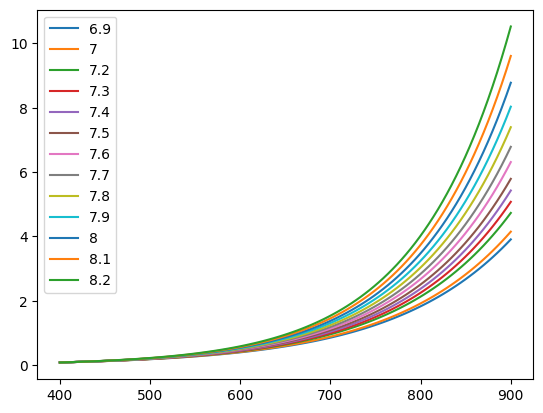

In [177]:
sample_xs = np.linspace( 400, 900, 100 )
sample_xs.shape
for key, mod in models.items():
    plt.plot(sample_xs, mod.eval(x=sample_xs), label=key)
plt.legend()
plt.show()

In [178]:
vs = []
print(models.keys())
for ph, fit in models.items():
    for orp in range(400, 900):
        fc = fit.eval(x=orp)        
        vs.append((float(orp), float(ph), float(fc)))

for fc, fit in phmodels.items():
    for x in range(40, 100):
        ph = x / 10
        orp = fit.eval(x=ph)
        vs.append((float(orp), ph, float(fc)))

dataset = pd.DataFrame(vs, columns= ('orp', 'ph', 'fc'))
dataset.describe()

dict_keys(['6.9', '7', '7.2', '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2'])


,orp,ph,fc
count,7880.000000,7880.000000,7880.000000
mean,659.635583,7.473477,1.428691
std,142.017722,0.844997,1.635947
min,400.000000,4.000000,0.085962
25%,543.219054,7.200000,0.300000
50%,661.000000,7.600000,0.808734
75%,777.412397,7.900000,1.912391
max,1043.228871,9.900000,10.422338


In [179]:
#import random
#lst = list(models.keys())
#train = random.sample(lst, k=round(len(lst) * 0.8))
#test = list(set(lst) - set(train))

#train_dataset = pd.DataFrame()
#for v in train:
#    data = dataset[dataset['ph'] == float(v)]
#    train_dataset = pd.concat( (data, train_dataset))

#test_dataset = pd.DataFrame()
#for v in test:
#    data = dataset[dataset['ph'] == float(v)]
#    test_dataset = pd.concat( (data, test_dataset))

#train_dataset = train_dataset.sample(frac=1.0)
#test_dataset = test_dataset.sample(frac=1.0)


train_dataset = dataset.sample(frac=0.8)#, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
train_labels = train_features.pop(TARGET)
train_labels = np.array(train_labels.to_list(), dtype=np.float64)

test_features = test_dataset.copy()
test_labels = test_features.pop(TARGET)
test_labels = np.array(test_labels.to_list(), dtype=np.float64)


print(train_dataset.describe().transpose()[['mean', 'std']])
#sns.pairplot(train_dataset, diag_kind='kde')

inorm = keras.layers.Normalization(axis=-1, input_shape=[2, ])
inorm.adapt(np.array(train_features))

onorm = keras.layers.Normalization(axis=None, invert=True)
onorm.adapt(np.array(train_labels))


           mean         std
orp  660.016221  142.055115
ph     7.467592    0.848578
fc     1.426010    1.631320


In [188]:
checkpoint_filepath = 'checkpoint0.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

def build_and_compile_model(inorm, onorm):
  model = keras.Sequential([
      inorm,
      keras.layers.Dense(4, activation='elu'),
      keras.layers.Dense(8, activation='elu'),
      keras.layers.Dense(1), 
      onorm,
  ])
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model
model = build_and_compile_model(inorm, onorm)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_18 (Normaliz  (None, 2)                 5         
 ation)                                                          
                                                                 
 dense_38 (Dense)            (None, 8)                 24        
                                                                 
 dense_39 (Dense)            (None, 4)                 36        
                                                                 
 dense_40 (Dense)            (None, 1)                 5         
                                                                 
 normalization_19 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
Total params: 73 (300.00 Byte)
Trainable params: 65 (

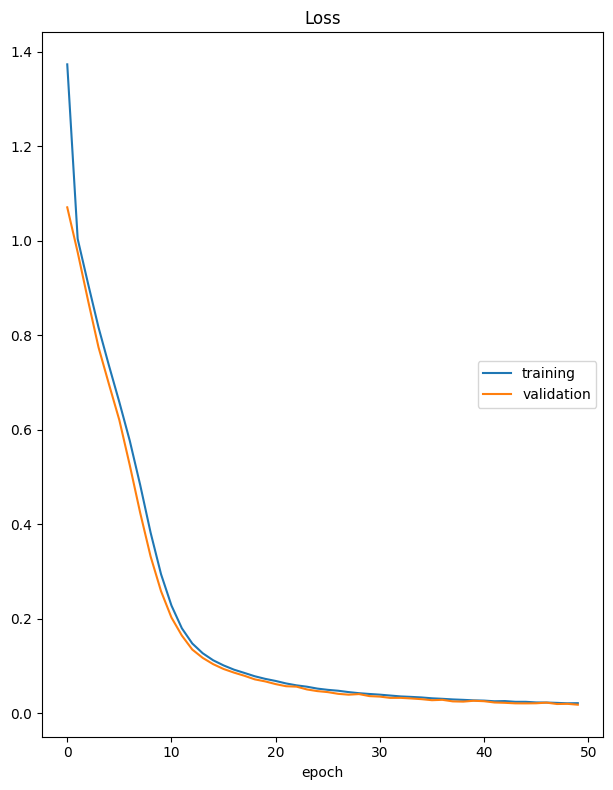

Loss
	training         	 (min:    0.021, max:    1.373, cur:    0.021)
	validation       	 (min:    0.018, max:    1.071, cur:    0.018)
158/158 [==============================] - 1s 4ms/step - loss: 0.0213 - val_loss: 0.0181
mse: 0.019050341099500656


In [189]:
history = model.fit(
    train_features,
    train_labels,
    validation_split= 0.2,
    verbose=1, epochs=50, callbacks=[PlotLossesKeras(), model_checkpoint_callback])
print('mse:', model.evaluate(test_features, test_labels, verbose=0))

<Axes: >

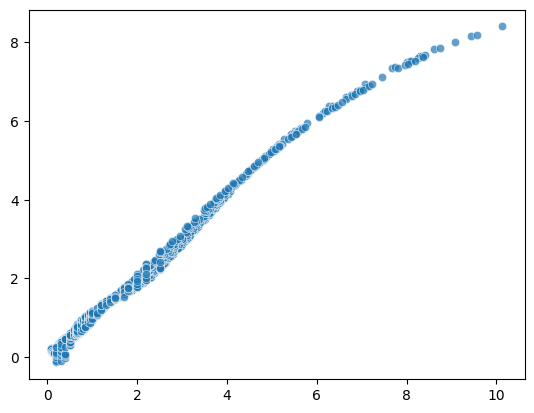

In [190]:
fmodel = checkpoint_filepath
#fmodel = 'model_fc.keras'

model = keras.models.load_model(fmodel)
y = model.predict(test_features, verbose=0)
y = pd.DataFrame(y)[0]
sns.scatterplot(x=test_labels, y=y.to_numpy(), alpha=0.7)

In [12]:
#model from  rasppool project
def rasppool_convert(orp_mean, ph_mean):
  # Some example values:
  e_fc_adjust = 0;	# FC Adjustment in percentage
  e_fc = round( 0.23 * (1 - e_fc_adjust) * (14 - ph_mean) ** (1/(400 - orp_mean))*(ph_mean - 4.1) ** ( (orp_mean - 516)/145) + 10.0 ** ( (orp_mean + ph_mean * 70 - 1282 ) / 40 ), 1 );
  return e_fc

def rasppool_predict(df):
    return [rasppool_convert(v[0], v[1]) for v in df.to_numpy()]   

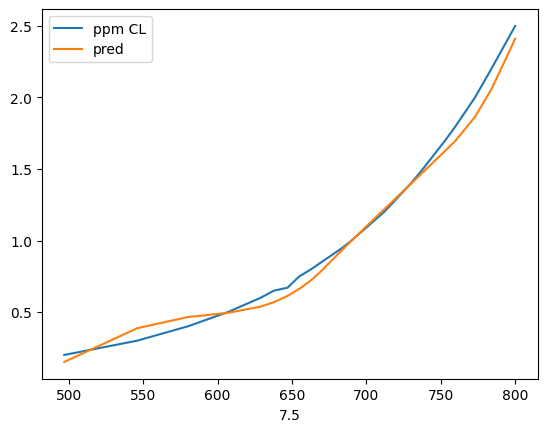

In [191]:
ph = 7.5
x = df[[str(ph),  'ppm CL']]
x = x.assign(ph=ph)
#new_row = {str(ph) : p0, 'ppm CL': 3, 'ph' : ph}
#x.loc[len(df.index)] = [p0, models[str(ph)].eval(x=p0), ph] 

x['pred'] = model.predict(x[[str(ph), 'ph']], verbose=0)
#x['rasp'] = rasppool_predict(x[[str(ph), 'ph']])

x.plot(x=str(ph), y=["ppm CL", "pred" ]);

In [335]:
model.save(f'model_{TARGET}.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(f'model_{TARGET}.tflite', "wb") as f:
  f.write(tflite_model)
print('done')

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpqu5ywuyk\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpqu5ywuyk\assets


done


In [184]:
#calibrated pH and ORP to  Reference 3ppm  -> 1.3 ppm output
p0 = 626
p1 = 7.5

#calibration value to convert 1.3ppm to 3ppm
offset = 100
p0 += offset

print(p0, p1)
v = model.predict(np.array([(p0, p1)]), verbose=0)[0][0]
print('output: ', v, v*2.25)

726 7.5
output:  1.3407092 3.016595721244812


In [185]:

phs = np.linspace(60, 90, 150) / 10
orps = np.linspace(400, 1100, 150 )
vals0 =  pd.DataFrame()
for ph in phs:
    val = np.array([ph] * len(orps))
    x = np.array(list(zip(orps, val )))
    d = pd.DataFrame(x, columns= ['orp', 'ph'])
    d['ppm'] = model.predict(x, verbose=False)
    vals0 = pd.concat((vals0, d))


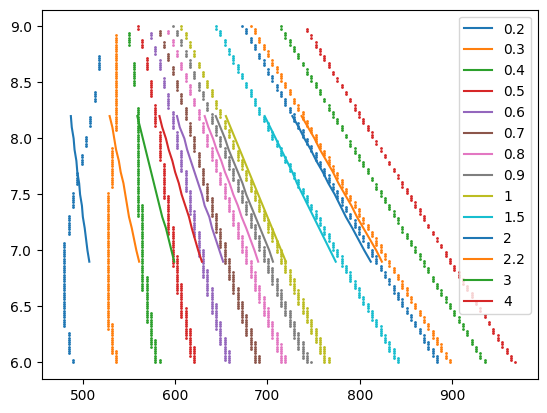

In [186]:
ppms = df['ppm CL']

#ppms = [2, 2.2, 2.5]

ppms = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.2, 3, 4]
plt.figure()
for ppm in ppms:
    data =dataset_orig.loc[dataset_orig['fc'] == ppm]
    plt.plot(data[['orp']], data[[ 'ph']], label=str(ppm))    
    predictions = vals0[vals0['ppm'].between(ppm*0.98, ppm*1.02)]
    plt.scatter(predictions['orp'], predictions['ph'], s=1)
plt.legend(loc="upper right")
plt.show()

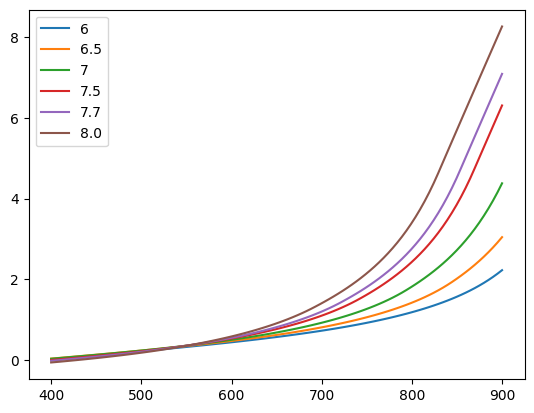

In [187]:
for key in [6, 6.5, 7, 7.5, 7.7, 8.0]:
    ph = np.array([key] * len(sample_xs))
    x = np.array(list(zip(sample_xs,ph)))
    plt.plot(sample_xs, model.predict(x, verbose=False), label=key)
plt.legend()
plt.show()